In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Create the inspector and connect it to the engine
Base = automap_base()
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
classes = Base.classes.keys()
print(f"The classes are: {classes}.")
Measurement = Base.classes.measurement
Station = Base.classes.station

# reflect the tables
inspector = inspect(engine)
tables = inspector.get_table_names()
print(f"The tables are: {classes}.")

The classes are: ['measurement', 'station'].
The tables are: ['measurement', 'station'].


In [7]:
# Save references to each table
for table in tables:
    print(f"{table} table:")
    print("-"*12)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

measurement table:
------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
station table:
------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [9]:
def print_measurement(measurement):
    print(f"ID: {measurement.id}")
    print(f"station: {measurement.station}")
    print(f"date: {measurement.date}")
    print(f"prcp: {measurement.prcp}")
    print(f"tobs: {measurement.tobs}")
    
def print_station(station):
    print(f"ID: {station.id}")
    print(f"station: {station.station}")
    print(f"name: {station.name}")
    print(f"latitude: {station.latitude}")
    print(f"longitude: {station.longitude}")
    print(f"elevation: {station.elevation}")
    
measurements = session.query(Measurement)
for measurement in measurements:
        print_measurement(measurement)

ID: 1
station: USC00519397
date: 2010-01-01
prcp: 0.08
tobs: 65.0
ID: 2
station: USC00519397
date: 2010-01-02
prcp: 0.0
tobs: 63.0
ID: 3
station: USC00519397
date: 2010-01-03
prcp: 0.0
tobs: 74.0
ID: 4
station: USC00519397
date: 2010-01-04
prcp: 0.0
tobs: 76.0
ID: 5
station: USC00519397
date: 2010-01-06
prcp: None
tobs: 73.0
ID: 6
station: USC00519397
date: 2010-01-07
prcp: 0.06
tobs: 70.0
ID: 7
station: USC00519397
date: 2010-01-08
prcp: 0.0
tobs: 64.0
ID: 8
station: USC00519397
date: 2010-01-09
prcp: 0.0
tobs: 68.0
ID: 9
station: USC00519397
date: 2010-01-10
prcp: 0.0
tobs: 73.0
ID: 10
station: USC00519397
date: 2010-01-11
prcp: 0.01
tobs: 64.0
ID: 11
station: USC00519397
date: 2010-01-12
prcp: 0.0
tobs: 61.0
ID: 12
station: USC00519397
date: 2010-01-14
prcp: 0.0
tobs: 66.0
ID: 13
station: USC00519397
date: 2010-01-15
prcp: 0.0
tobs: 65.0
ID: 14
station: USC00519397
date: 2010-01-16
prcp: 0.0
tobs: 68.0
ID: 15
station: USC00519397
date: 2010-01-17
prcp: 0.0
tobs: 64.0
ID: 16
station:

ID: 18463
station: USC00516128
date: 2014-06-08
prcp: 0.29
tobs: 73.0
ID: 18464
station: USC00516128
date: 2014-06-09
prcp: 1.0
tobs: 70.0
ID: 18465
station: USC00516128
date: 2014-06-10
prcp: 0.11
tobs: 70.0
ID: 18466
station: USC00516128
date: 2014-06-11
prcp: 0.57
tobs: 76.0
ID: 18467
station: USC00516128
date: 2014-06-12
prcp: 0.02
tobs: 72.0
ID: 18468
station: USC00516128
date: 2014-06-13
prcp: 0.01
tobs: 73.0
ID: 18469
station: USC00516128
date: 2014-06-14
prcp: 0.0
tobs: 77.0
ID: 18470
station: USC00516128
date: 2014-06-15
prcp: 0.03
tobs: 73.0
ID: 18471
station: USC00516128
date: 2014-06-16
prcp: 0.38
tobs: 70.0
ID: 18472
station: USC00516128
date: 2014-06-17
prcp: 1.45
tobs: 68.0
ID: 18473
station: USC00516128
date: 2014-06-18
prcp: 0.32
tobs: 69.0
ID: 18474
station: USC00516128
date: 2014-06-19
prcp: 0.2
tobs: 70.0
ID: 18475
station: USC00516128
date: 2014-06-20
prcp: 0.75
tobs: 70.0
ID: 18476
station: USC00516128
date: 2014-06-21
prcp: 0.09
tobs: 73.0
ID: 18477
station: USC0

In [10]:
stations = session.query(Station)
for station in stations:
        print(f"ID: {station.id}")
        print(f"station: {station.station}")
        print(f"name: {station.name}")
        print(f"latitude: {station.latitude}")
        print(f"longitude: {station.longitude}")
        print(f"elevation: {station.elevation}")

ID: 1
station: USC00519397
name: WAIKIKI 717.2, HI US
latitude: 21.2716
longitude: -157.8168
elevation: 3.0
ID: 2
station: USC00513117
name: KANEOHE 838.1, HI US
latitude: 21.4234
longitude: -157.8015
elevation: 14.6
ID: 3
station: USC00514830
name: KUALOA RANCH HEADQUARTERS 886.9, HI US
latitude: 21.5213
longitude: -157.8374
elevation: 7.0
ID: 4
station: USC00517948
name: PEARL CITY, HI US
latitude: 21.3934
longitude: -157.9751
elevation: 11.9
ID: 5
station: USC00518838
name: UPPER WAHIAWA 874.3, HI US
latitude: 21.4992
longitude: -158.0111
elevation: 306.6
ID: 6
station: USC00519523
name: WAIMANALO EXPERIMENTAL FARM, HI US
latitude: 21.33556
longitude: -157.71139
elevation: 19.5
ID: 7
station: USC00519281
name: WAIHEE 837.5, HI US
latitude: 21.45167
longitude: -157.84888999999998
elevation: 32.9
ID: 8
station: USC00511918
name: HONOLULU OBSERVATORY 702.2, HI US
latitude: 21.3152
longitude: -157.9992
elevation: 0.9
ID: 9
station: USC00516128
name: MANOA LYON ARBO 785.2, HI US
latitude

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement).order_by(desc('date')).first()
print(f"The most recent measurement date is {most_recent.date} at station {most_recent.station}")

The most recent measurement date is 2017-08-23 at station USC00519397


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
end_date = most_recent.date
end_date_strings = end_date.split("-")
year = int(end_date_strings[0])
#reconstruct the start date string
start_date = str(year-1) + "-" + end_date_strings[1] + "-" + end_date_strings[2]

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement).filter(Measurement.date >= start_date).all() 

# Save the query results as a Pandas DataFrame. Explicitly set the column names
dict_array = []
for measurement in last_year:
    m_dict = {
        'id': measurement.id,
        'station': measurement.station,
        'date': measurement.date,
        'prcp': measurement.prcp,
        'tobs': measurement.tobs,
    }
    dict_array.append(m_dict)

# create dataframe sorted by date
last_year_df = pd.DataFrame(dict_array, columns=['id', 'station','date','prcp','tobs']).sort_values('date')
#print(f"{last_year_df.rows})
last_year_df.dropna(inplace=True)

In [13]:

# Use Pandas Plotting with Matplotlib to plot the data
last_year_reorg_df = last_year_df.pivot(index="date",columns="station",values="prcp")
last_year_reorg_df

station,USC00513117,USC00514830,USC00516128,USC00517948,USC00519281,USC00519397,USC00519523
date,,,,,,,
2016-08-23,0.15,0.05,0.70,NaN,1.79,0.00,0.02
2016-08-24,2.15,2.28,1.45,NaN,2.15,0.08,1.22
2016-08-25,0.08,0.00,0.11,0.00,0.06,0.08,0.21
2016-08-26,0.03,0.02,NaN,0.04,0.01,0.00,0.00
2016-08-27,0.18,0.02,NaN,NaN,0.12,0.00,0.00
...,...,...,...,...,...,...,...
2017-08-19,NaN,0.00,0.09,NaN,NaN,0.00,NaN
2017-08-20,NaN,0.01,NaN,NaN,NaN,0.00,NaN
2017-08-21,NaN,0.02,0.56,NaN,NaN,0.00,NaN


In [14]:
first_week = last_year_reorg_df.head(7)
first_week

station,USC00513117,USC00514830,USC00516128,USC00517948,USC00519281,USC00519397,USC00519523
date,,,,,,,
2016-08-23,0.15,0.05,0.70,NaN,1.79,0.00,0.02
2016-08-24,2.15,2.28,1.45,NaN,2.15,0.08,1.22
2016-08-25,0.08,0.00,0.11,0.00,0.06,0.08,0.21
2016-08-26,0.03,0.02,NaN,0.04,0.01,0.00,0.00
2016-08-27,0.18,0.02,NaN,NaN,0.12,0.00,0.00
2016-08-28,0.14,0.14,2.07,NaN,0.60,0.01,0.14
2016-08-29,0.17,0.04,0.90,NaN,0.35,0.00,0.00


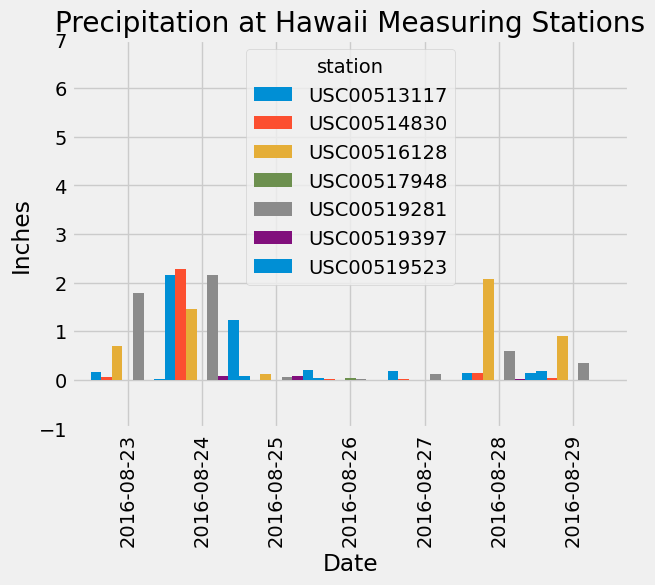

In [15]:
first_week.plot(kind='bar',ylim=(-1,7),xlabel="Date",ylabel="Inches",title="Precipitation at Hawaii Measuring Stations",width=1)

plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Defining function quantiles
def q50(x):
    return x.quantile(0.5)

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

prcp_agg = last_year_df.agg({'prcp': ['count','mean','std', 'min', q25, q50, q75, 'max']})
prcp_agg.rename(columns = {'prcp':'precipitation'}, index={'q25': '25%','q50': '50%','q75': '75%'}, inplace = True)
prcp_agg

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
unique_stations = session.query(Station.id, Station.station).distinct().count()
unique_stations

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activity = session.query(Measurement.station,func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = activity[0][0]
temp_data = session.query(Measurement.date,Measurement.station,Measurement.tobs).\
                            filter(Measurement.station == most_active_station).\
                            order_by(desc(Measurement.date)).all() 
temps = []
for temp in temp_data:
    temps.append(temp[2])
print(f"Lowest temperature: {min(temps)}")
print(f"Highest temperature: {max(temps)}")
print("Average temperature: " + "{:.2f}".format(np.mean(temps)))

Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66


In [20]:
# Using the most active station id

# Calculate the date one year from the last date in data set.
end_date = temp_data[0][0]
end_date_strings = end_date.split("-")
year = int(end_date_strings[0])
# construct the start date string
start_date = str(year-1) + "-" + end_date_strings[1] + "-" + end_date_strings[2]

# Query the last 12 months of temperature observation data for the most active station
last_year = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
            filter(Measurement.station == most_active_station).\
                   filter(Measurement.date >= start_date).all()
temps = []
for measurement in last_year:
    temps.append(measurement[2])
    
print(f"{len(temps)} values in temps")
print(f"{len(last_year)} values in last_year")
last_year


357 values in temps
357 values in last_year


[('2016-08-18', 'USC00519281', 80.0),
 ('2016-08-19', 'USC00519281', 79.0),
 ('2016-08-20', 'USC00519281', 81.0),
 ('2016-08-21', 'USC00519281', 79.0),
 ('2016-08-22', 'USC00519281', 78.0),
 ('2016-08-23', 'USC00519281', 77.0),
 ('2016-08-24', 'USC00519281', 77.0),
 ('2016-08-25', 'USC00519281', 80.0),
 ('2016-08-26', 'USC00519281', 80.0),
 ('2016-08-27', 'USC00519281', 75.0),
 ('2016-08-28', 'USC00519281', 73.0),
 ('2016-08-29', 'USC00519281', 78.0),
 ('2016-08-30', 'USC00519281', 77.0),
 ('2016-08-31', 'USC00519281', 78.0),
 ('2016-09-01', 'USC00519281', 80.0),
 ('2016-09-02', 'USC00519281', 80.0),
 ('2016-09-03', 'USC00519281', 78.0),
 ('2016-09-04', 'USC00519281', 78.0),
 ('2016-09-05', 'USC00519281', 78.0),
 ('2016-09-06', 'USC00519281', 73.0),
 ('2016-09-07', 'USC00519281', 74.0),
 ('2016-09-08', 'USC00519281', 80.0),
 ('2016-09-09', 'USC00519281', 79.0),
 ('2016-09-10', 'USC00519281', 77.0),
 ('2016-09-11', 'USC00519281', 80.0),
 ('2016-09-12', 'USC00519281', 76.0),
 ('2016-09-1

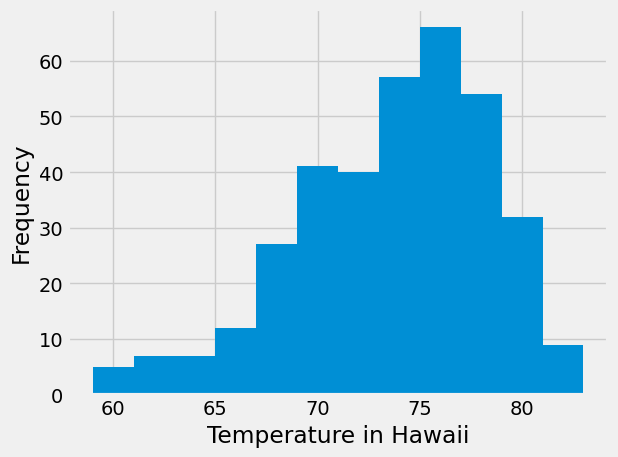

In [21]:

# plot the results as a histogram
fig, ax = plt.subplots(tight_layout=True)
ax.hist(temps,bins=12)
ax.set_xlabel("Temperature in Hawaii")
ax.set_ylabel("Frequency")
plt.show()

# Close Session

In [22]:
# Close Session
session.close()